In [1]:
import os, sys
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import gridspec
import numpy as np
import pandas as pd
from tqdm import *

from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator
from grf.grf import FIRAS

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
# Location of outputs of cluster runs
outputs_dir = "/Users/smsharma/chi2_arys/"

# Where to save plots
plots_dir = "../paper/draft-formalism/plots/"

In [8]:
# Load an instance of FIRAS class with nonlinear matter power spectrum
firas = FIRAS(PowerSpectrumGridInterpolator("lin_baryon"))

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


## Plasma mass plot (Fig. 2)

In [9]:
def as_si(x, ndp, dolla=0):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    if float(m) == 1.:
        s = r'10^{{{e:d}}}'.format(m=m, e=int(e))
    else:
        s = r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    if dolla:
        return '$' + s + '$'
    else:
        return s

In [15]:
omega_ary = np.array([1e-4, 5e-4, 1e-3, 5e-3]) * eV

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


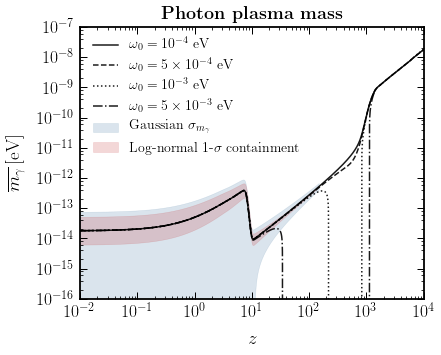

In [28]:
# fig = plt.figure(figsize=(8 / 1.3, 7.5 / 1.3)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1], hspace=0.08) 

# Top plot
ax0 = plt.subplot(gs[0])

## Frequency bins to plot
i_freq_ary = [0, 1, 2, 3]

z_ary_plot = np.logspace(-2, 4, 30000)

ls_list = ['-','--',':','-.']

## Plot central values
for i_en_freq_ry, i_freq in enumerate(i_freq_ary):
    m_A_sq = firas.m_A_sq(z_ary_plot, omega_ary[i_freq] * (1 + z_ary_plot))
    m_A_sq[m_A_sq < 0] = 0
    
    if i_freq != 3:  
        ax0.plot(z_ary_plot, np.sqrt(m_A_sq) / eV , label=r"$\omega_0 = "  + as_si(omega_ary[i_freq] / eV, 0) + "\,\,\mathrm{eV}$", ls=ls_list[i_en_freq_ry], color='k', lw=1.5)
    else:
        ax0.plot(z_ary_plot[z_ary_plot < 1500], np.sqrt(m_A_sq)[z_ary_plot < 1500] / eV , label=r"$\omega_0 = "  + as_si(omega_ary[i_freq] / eV, 0) + "\,\,\mathrm{eV}$", ls=ls_list[i_en_freq_ry], color='k', lw=1.5)
        
## For the first frequency bin, plot 1- and 2-sigma containment regions

i_freq = 0

z_ary_fluc, dP_dz_ary, P_tot, sigma_sq_ary = firas.P_tot_perturb([omega_ary[i_freq]], 1e-1, 1e-15 * eV, k_max=1e3, pdf='gaussian')
m_A_ary = (firas.m_A_sq(z_ary_fluc, omega_ary[i_freq] * (1 + z_ary_fluc))) / eV ** 2

ax0.fill_between(z_ary_fluc,  np.nan_to_num(np.sqrt(m_A_ary) - 1 * (sigma_sq_ary[0]) ** 0.25 / eV) , np.nan_to_num(np.sqrt(m_A_ary) + 1. * (sigma_sq_ary[0]) ** 0.25 / eV), alpha=0.2, color=cols_default[1], lw=0.5, label="Gaussian $\sigma_{m_\gamma}$")

z_ary_fluc, dP_dz_ary, P_tot, sigma_sq_ary = firas.P_tot_perturb([omega_ary[i_freq]], 1e-1, 1e-15 * eV, k_max=1e3, pdf='lognormal')
m_A_ary = (firas.m_A_sq(z_ary_fluc, omega_ary[i_freq] * (1 + z_ary_fluc))) / eV ** 2

ax0.fill_between(z_ary_fluc,  np.nan_to_num(np.sqrt(m_A_ary * np.exp(- 1 * np.sqrt(sigma_sq_ary[0])))) , np.nan_to_num(np.sqrt(m_A_ary * 1 * np.exp(np.sqrt(sigma_sq_ary[0])))), alpha=0.2, color=cols_default[0], lw=0.5, label=r"Log-normal 1-$\sigma$ containment")

ax0.set_xscale("log")
ax0.set_yscale("log")

ax0.set_xlim(np.min(z_ary_plot), np.max(z_ary_plot))
ax0.set_ylim(1e-16, 1e-7)

ax0.set_ylabel("$\overline{m_\gamma}$\,[eV]")
ax0.set_xlabel("$z$")

ax0.legend(fontsize=14, ncol=1, handlelength=1.8, loc='upper left')

plt.title(r"\textbf{Photon plasma mass}")

# Tick tweaks

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax0.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.savefig(plots_dir + "m_Ap_single_LN.pdf", bbox_inches='tight')